Importing Packages

In [1]:
import os
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
import xgboost as xgb 
import pickle

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

import datetime
import itertools
import warnings
warnings.filterwarnings('ignore')


np.set_printoptions(formatter={'float_kind':'{:f}'.format})

sns.set(rc={'figure.figsize':(8,7)})

Loading the file

In [2]:
data = pd.read_csv(r'data.csv')

Check data type and data summary

In [3]:
print("Total Number of columns : ", len(data.columns))
print("List of columns :", data.columns.tolist())
data.head()

Total Number of columns :  22
List of columns : ['customer_registration_number', 'merchandize_category', 'amount_deposited_via_counter', 'amount_deposited_via_card', 'balance_on_complaign_date', 'transaction_date', 'complaint_date', 'restaurant_points', 'fuel_points', 'groceries_points', 'toys_points', 'cash_back_points', 'electronics', 'complained', 'Order_tyPe', 'amount', 'quantity', 'card_vendor', 'used_coupon', 'product_discounted', 'cust_age', 'cust_gender']


,customer_registration_number,merchandize_category,amount_deposited_via_counter,amount_deposited_via_card,balance_on_complaign_date,transaction_date,complaint_date,restaurant_points,fuel_points,groceries_points,...,electronics,complained,Order_tyPe,amount,quantity,card_vendor,used_coupon,product_discounted,cust_age,cust_gender
0,64257fd79a53006421b72c3f,Breakfast,0.0,779.00,1272.00,2023-03-15,2023-03-29,0,0,0,...,0,YES,Other,1.0,1.0,Visa,No,no,49,Female
1,64257ffc9a53006421b72c40,Frozen,0.0,536.00,928.00,2023-03-15,2023-03-29,0,1,0,...,0,YES,Pickup,3000.0,1.0,Visa,No,no,82,Female
2,642580229a53006421b72c41,Alcohol,0.0,330225.00,177850.00,2023-03-15,2023-03-29,0,0,0,...,0,NO,Walk In,22000.0,1.0,Visa,No,no,35,Male
3,642580469a53006421b72c42,Baking,0.0,6215561.04,301542.04,2023-03-15,2023-03-29,3,0,1,...,0,NO,Walk In,1600000.0,5.0,Mastercard,No,YEs,95,Female
4,642580469a53006421b72c42,Alcohol,0.0,6215561.04,301542.04,2023-03-15,2023-03-29,3,0,1,...,0,NO,Walk In,1600000.0,5.0,Mastercard,No,YEs,95,Female


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31924 entries, 0 to 31923
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_registration_number  31924 non-null  object 
 1   merchandize_category          26843 non-null  object 
 2   amount_deposited_via_counter  31924 non-null  float64
 3   amount_deposited_via_card     31924 non-null  float64
 4   balance_on_complaign_date     31924 non-null  float64
 5   transaction_date              31924 non-null  object 
 6   complaint_date                31924 non-null  object 
 7   restaurant_points             31924 non-null  int64  
 8   fuel_points                   31924 non-null  int64  
 9   groceries_points              31924 non-null  int64  
 10  toys_points                   31924 non-null  int64  
 11  cash_back_points              31924 non-null  int64  
 12  electronics                   31924 non-null  int64  
 13  c

### Data Wrangling

Checking null values and missing data

In [5]:
columns_with_null_values = [(col, data[col].isnull().sum()) for col in data.columns.tolist() if data[col].isnull().sum() > 0]
columns_with_null_values

[('merchandize_category', 5081), ('amount', 213), ('quantity', 249)]

In [6]:
# replacing na values in "merchandize_category" with "Not Applicable"
data["merchandize_category"].fillna("Not Applicable", inplace = True)

# replacing na values in "amount" with "0"
data["amount"].fillna("0.0", inplace = True)

# replacing na quantity in "amount" with "0"
data["quantity"].fillna("0.0", inplace = True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31924 entries, 0 to 31923
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_registration_number  31924 non-null  object 
 1   merchandize_category          31924 non-null  object 
 2   amount_deposited_via_counter  31924 non-null  float64
 3   amount_deposited_via_card     31924 non-null  float64
 4   balance_on_complaign_date     31924 non-null  float64
 5   transaction_date              31924 non-null  object 
 6   complaint_date                31924 non-null  object 
 7   restaurant_points             31924 non-null  int64  
 8   fuel_points                   31924 non-null  int64  
 9   groceries_points              31924 non-null  int64  
 10  toys_points                   31924 non-null  int64  
 11  cash_back_points              31924 non-null  int64  
 12  electronics                   31924 non-null  int64  
 13  c

In [8]:
#data type of amount & quantity column is object - as it contains null values as blank space strings
#we need to replace that with 0.0
data["quantity"] = np.where(data["quantity"] == " ", '0.0', data["quantity"])
data["quantity"] = data["quantity"].astype(float)

data["amount"] = np.where(data["amount"] == " ", '0.0', data["amount"])
data["amount"] = data["amount"].astype(float)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31924 entries, 0 to 31923
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_registration_number  31924 non-null  object 
 1   merchandize_category          31924 non-null  object 
 2   amount_deposited_via_counter  31924 non-null  float64
 3   amount_deposited_via_card     31924 non-null  float64
 4   balance_on_complaign_date     31924 non-null  float64
 5   transaction_date              31924 non-null  object 
 6   complaint_date                31924 non-null  object 
 7   restaurant_points             31924 non-null  int64  
 8   fuel_points                   31924 non-null  int64  
 9   groceries_points              31924 non-null  int64  
 10  toys_points                   31924 non-null  int64  
 11  cash_back_points              31924 non-null  int64  
 12  electronics                   31924 non-null  int64  
 13  c

### Data Exploratory Analysis (EDA)

In [9]:
for col in data.columns.tolist():
    print(col)
    print("Number of unique values:", data[col].nunique())
    print("Unique Values:", data[col].unique()[:10])
    
    if(data[col].dtype == 'int64' or data[col].dtype == 'float64'):
        print("max :", data[col].max())
        print("min :", data[col].min())
        print("mean :", data[col].mean())
        print("std :", data[col].std())

    print()

customer_registration_number
Number of unique values: 23964
Unique Values: ['64257fd79a53006421b72c3f' '64257ffc9a53006421b72c40'
 '642580229a53006421b72c41' '642580469a53006421b72c42'
 '642580659a53006421b72c43' '642580879a53006421b72c44'
 '642580a79a53006421b72c45' '642580ed9a53006421b72c46'
 '6425810e9a53006421b72c47' '642581549a53006421b72c48']

merchandize_category
Number of unique values: 24
Unique Values: ['Breakfast' 'Frozen' 'Alcohol' 'Baking' 'Guns and weaponry' 'Condiment'
 'Not Applicable' 'others' 'Dairy' 'Meat & Seafood']

amount_deposited_via_counter
Number of unique values: 411
Unique Values: [0.000000 997055.000000 54100.000000 4100.000000 14100.000000 20000.000000
 9100.000000 15000.000000 50.000000 100000.000000]
max : 700000000.0
min : -5900.0
mean : 113725.17820041347
std : 4752873.46898347

amount_deposited_via_card
Number of unique values: 10112
Unique Values: [779.000000 536.000000 330225.000000 6215561.040000 71197.000000
 997055.000000 4100.000000 53700.000000

In [10]:
data.columns

Index(['customer_registration_number', 'merchandize_category',
       'amount_deposited_via_counter', 'amount_deposited_via_card',
       'balance_on_complaign_date', 'transaction_date', 'complaint_date',
       'restaurant_points', 'fuel_points', 'groceries_points', 'toys_points',
       'cash_back_points', 'electronics', 'complained', 'Order_tyPe', 'amount',
       'quantity', 'card_vendor', 'used_coupon', 'product_discounted',
       'cust_age', 'cust_gender'],
      dtype='object')

In [11]:
new_data =data[['merchandize_category',
       'amount_deposited_via_counter', 'amount_deposited_via_card',
       'balance_on_complaign_date',
       'restaurant_points', 'fuel_points', 'groceries_points', 'toys_points',
       'cash_back_points', 'electronics', 'complained', 'Order_tyPe', 'amount',
       'quantity', 'card_vendor', 'used_coupon', 'product_discounted',
       'cust_age', 'cust_gender']]

new_data.head()

,merchandize_category,amount_deposited_via_counter,amount_deposited_via_card,balance_on_complaign_date,restaurant_points,fuel_points,groceries_points,toys_points,cash_back_points,electronics,complained,Order_tyPe,amount,quantity,card_vendor,used_coupon,product_discounted,cust_age,cust_gender
0,Breakfast,0.0,779.00,1272.00,0,0,0,0,0,0,YES,Other,1.0,1.0,Visa,No,no,49,Female
1,Frozen,0.0,536.00,928.00,0,1,0,0,0,0,YES,Pickup,3000.0,1.0,Visa,No,no,82,Female
2,Alcohol,0.0,330225.00,177850.00,0,0,0,0,1,0,NO,Walk In,22000.0,1.0,Visa,No,no,35,Male
3,Baking,0.0,6215561.04,301542.04,3,0,1,0,1,0,NO,Walk In,1600000.0,5.0,Mastercard,No,YEs,95,Female
4,Alcohol,0.0,6215561.04,301542.04,3,0,1,0,1,0,NO,Walk In,1600000.0,5.0,Mastercard,No,YEs,95,Female


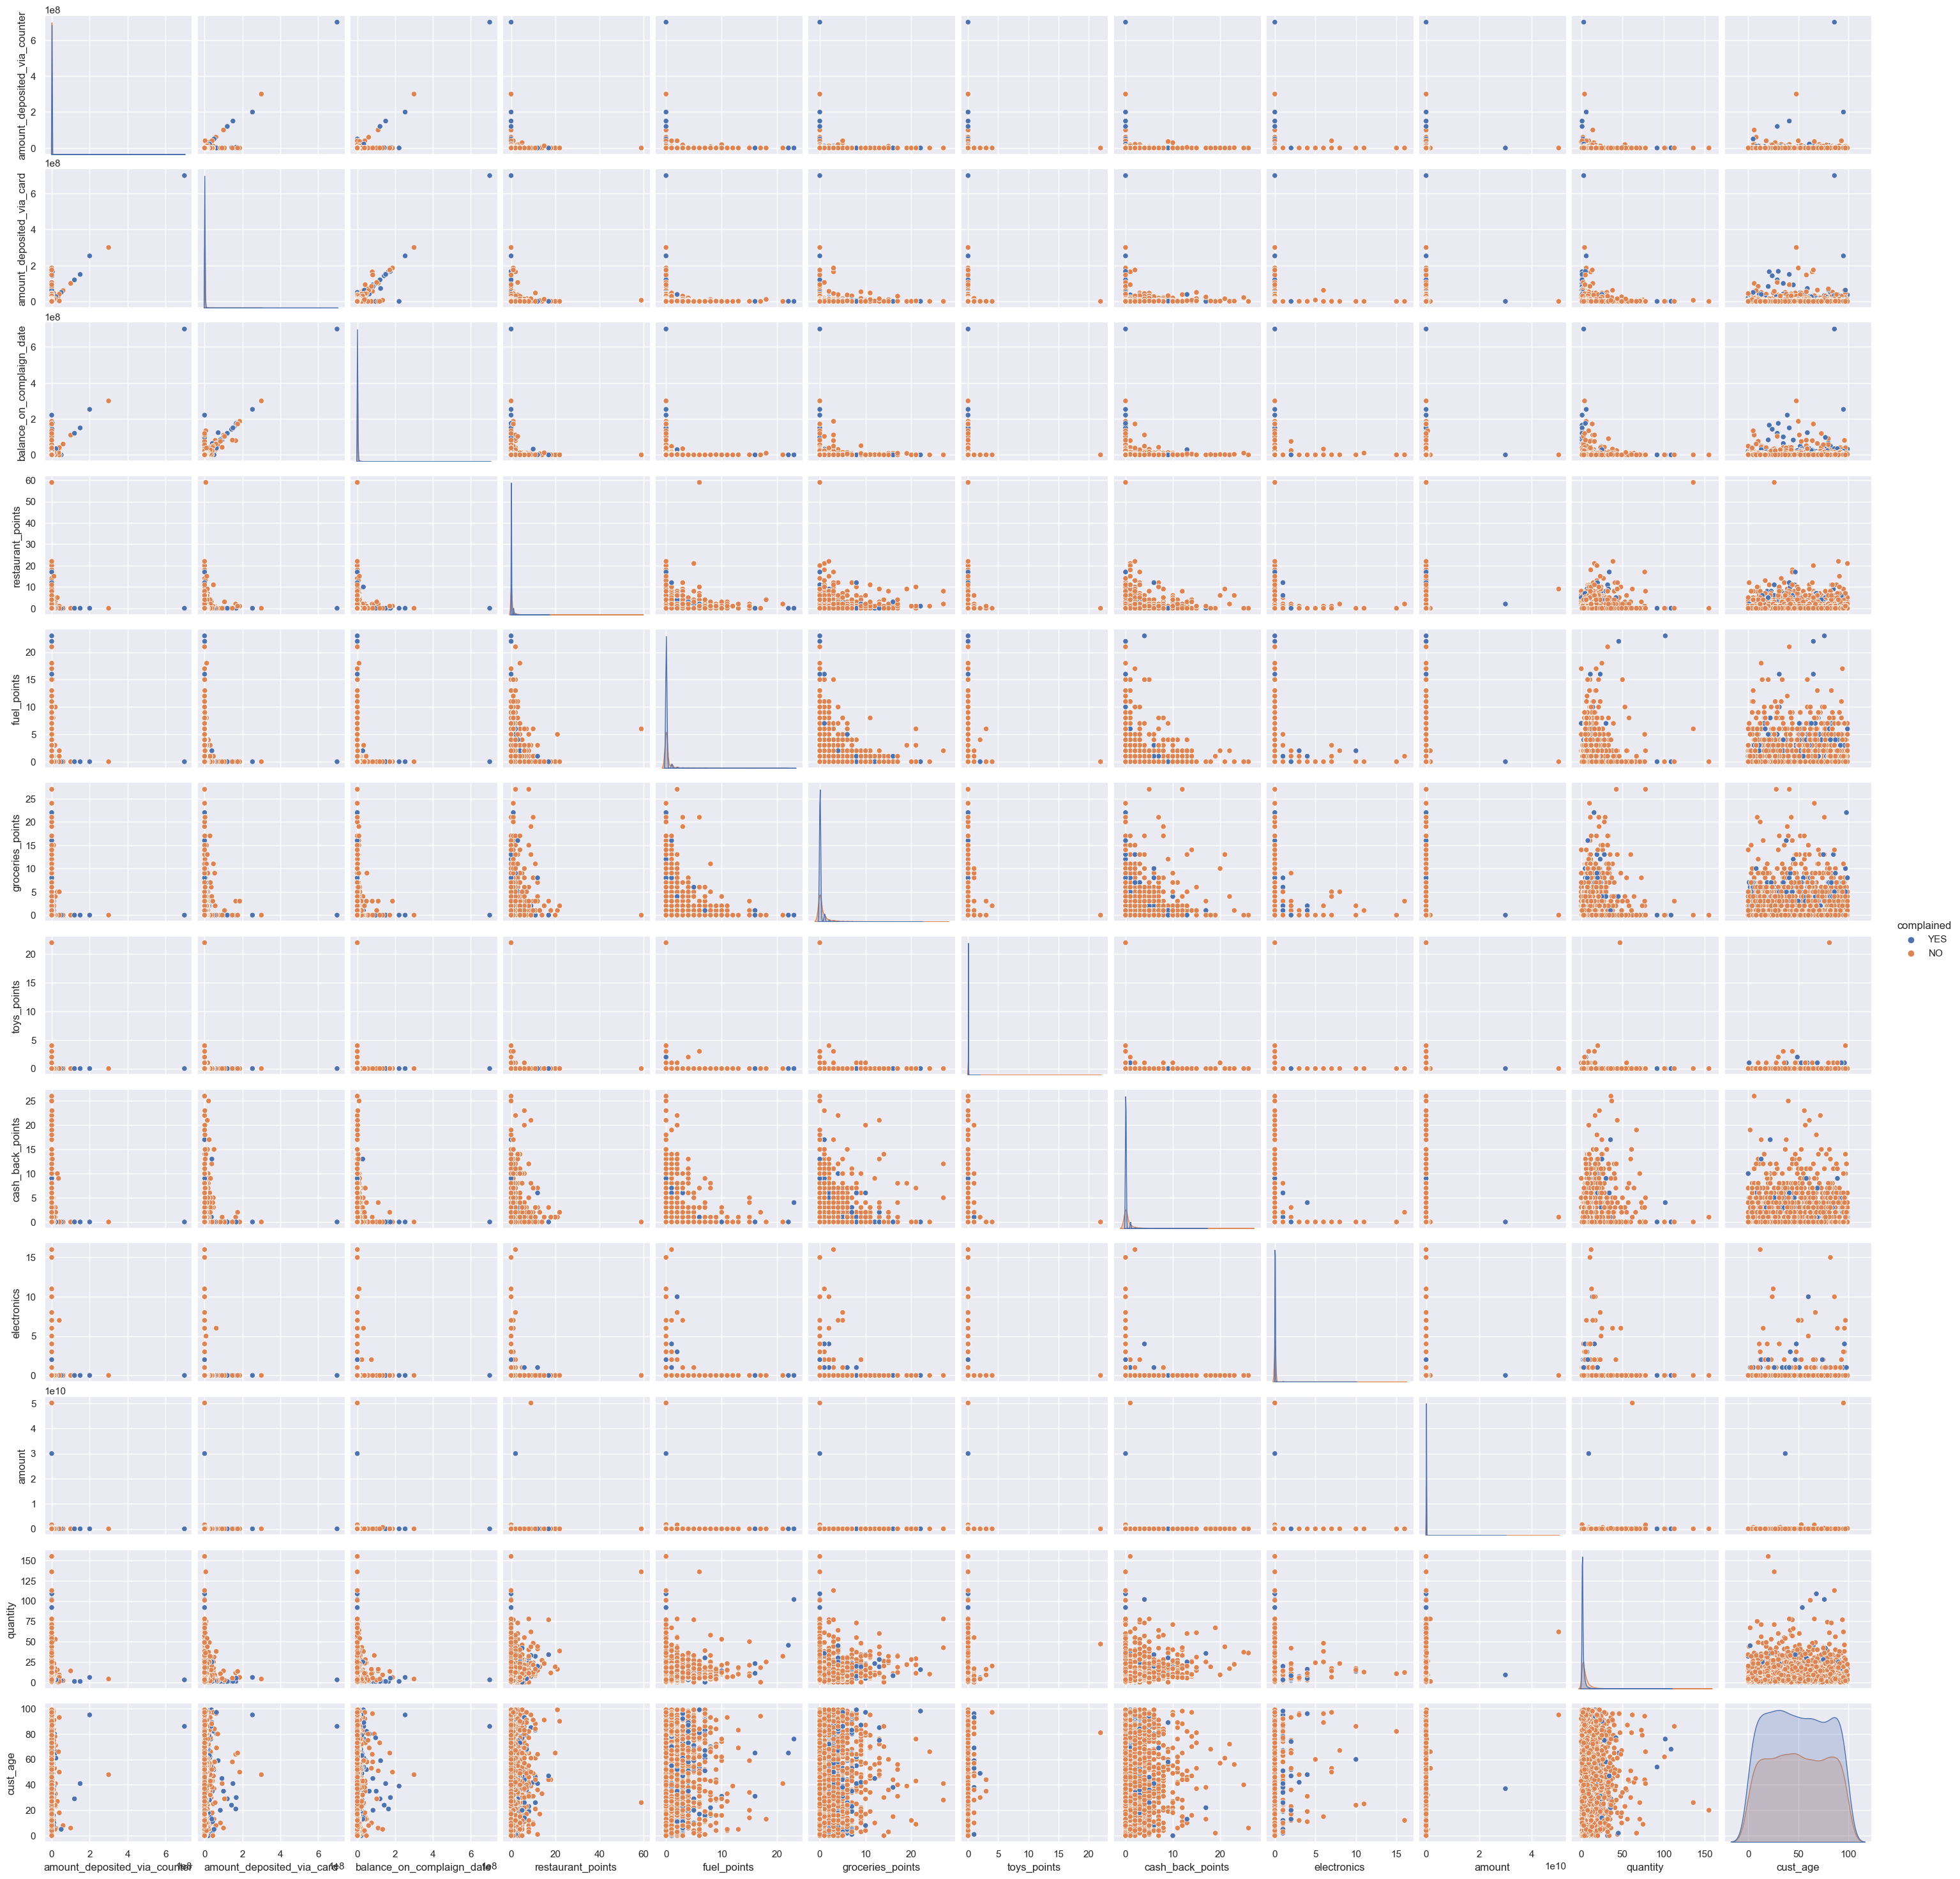

In [12]:
#Visualize the data

f = sns.pairplot(new_data, hue= 'complained', diag_kws={'bw': 0.2})

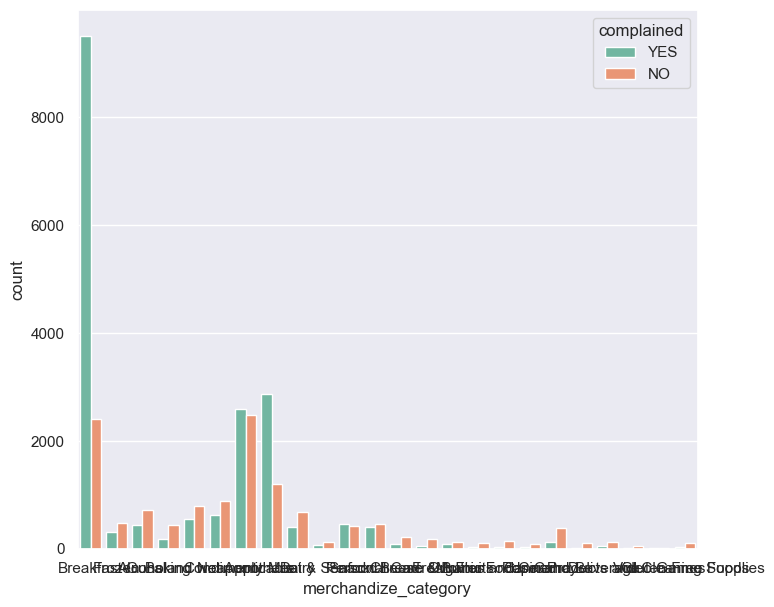

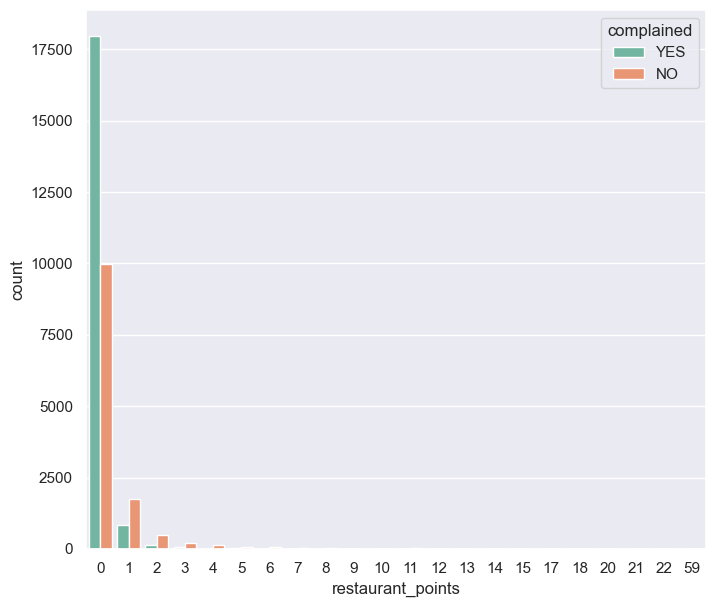

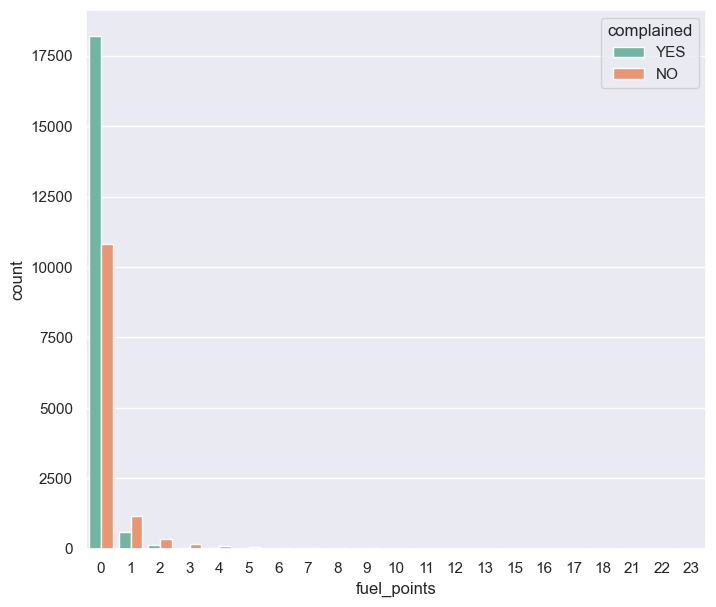

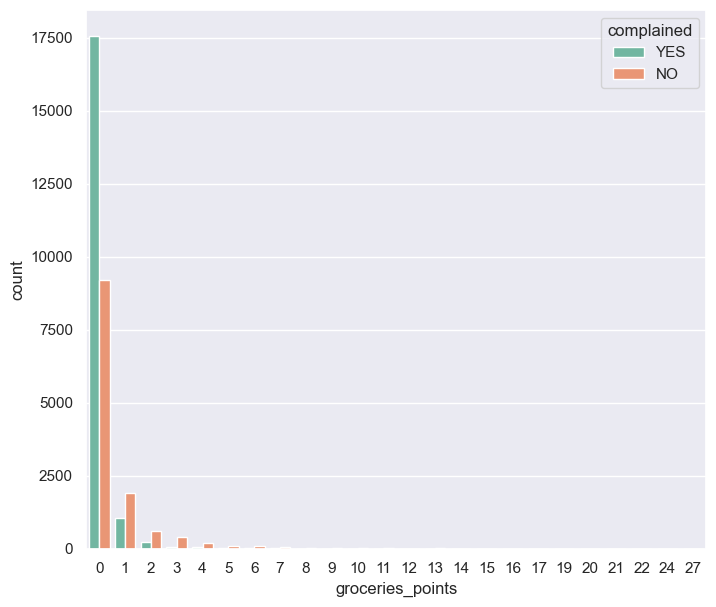

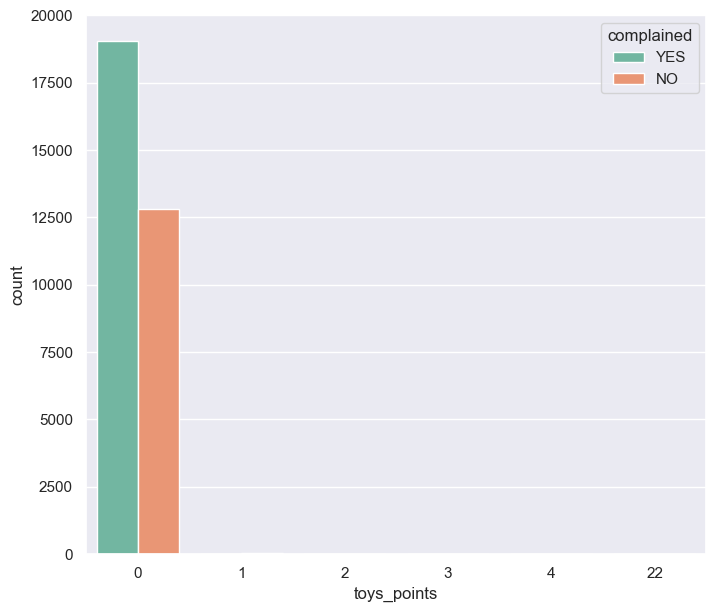

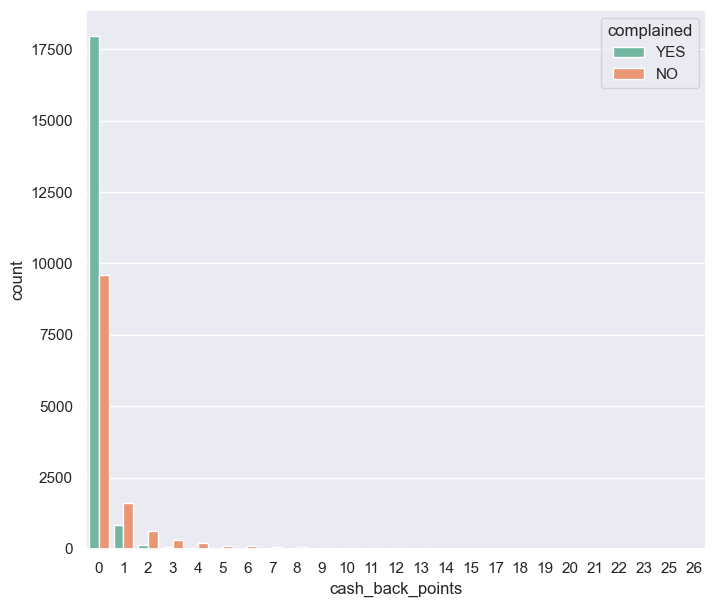

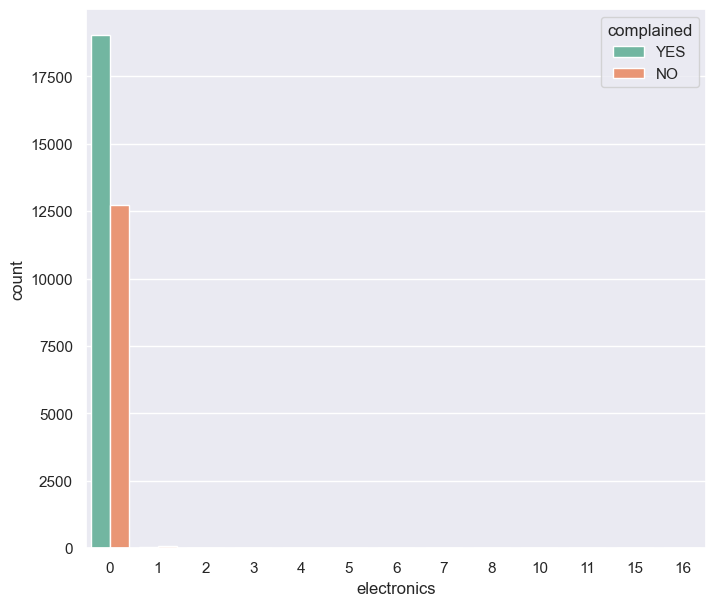

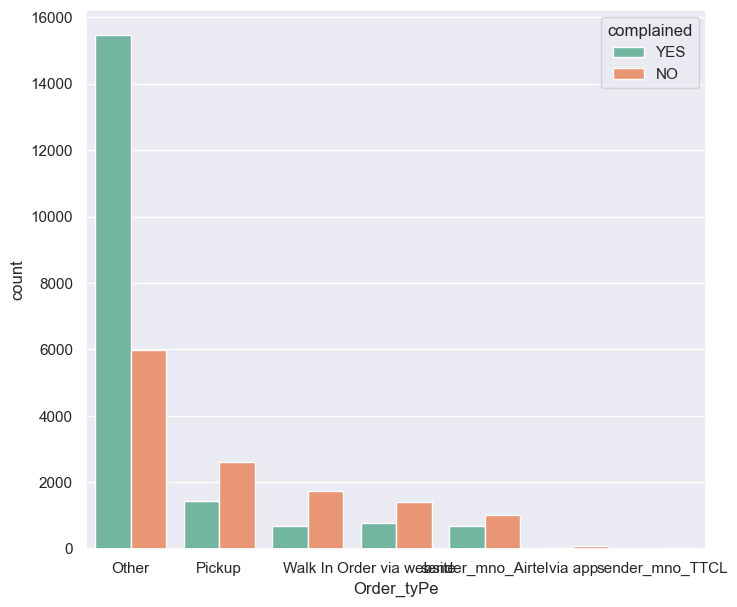

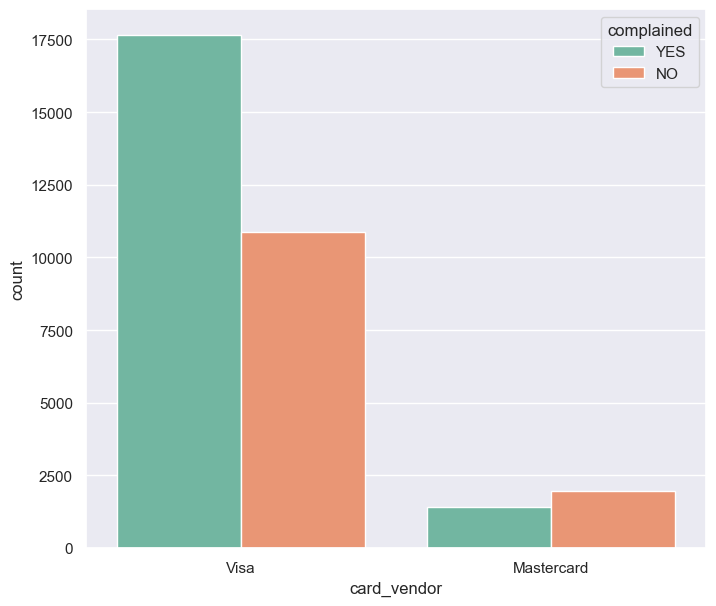

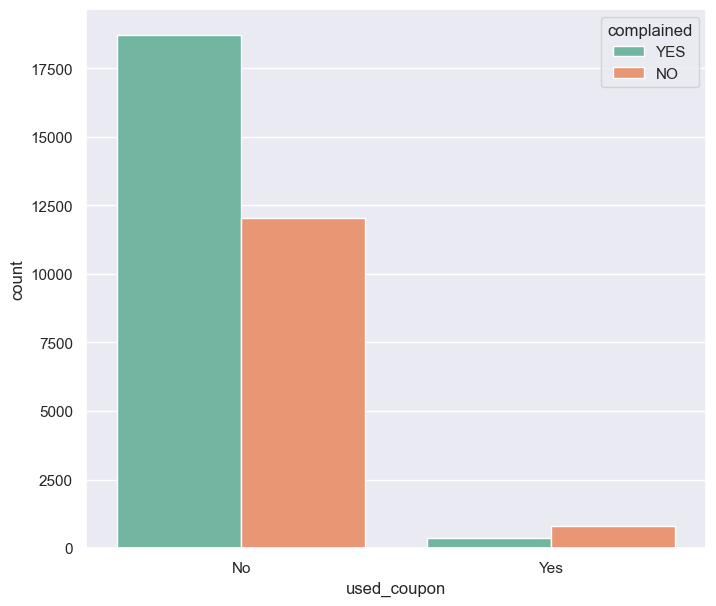

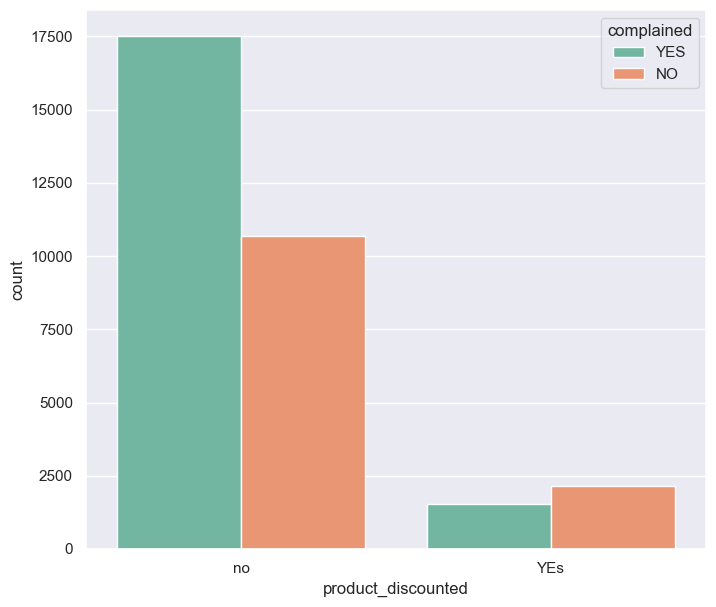

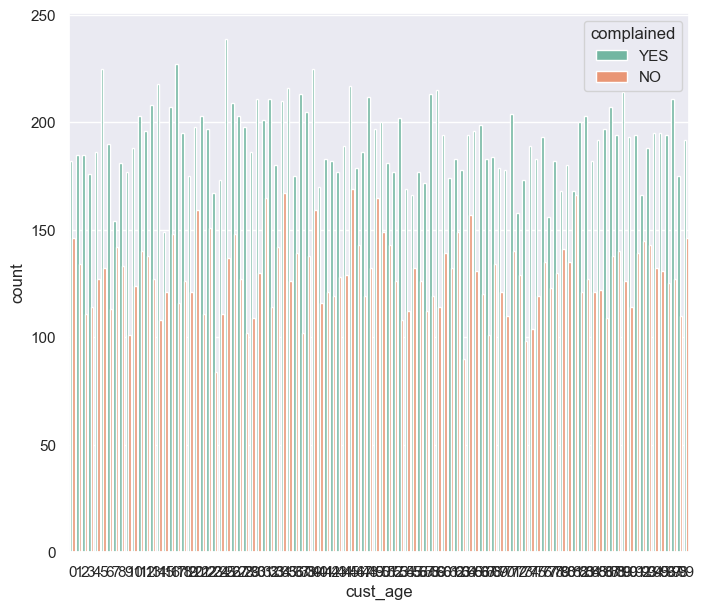

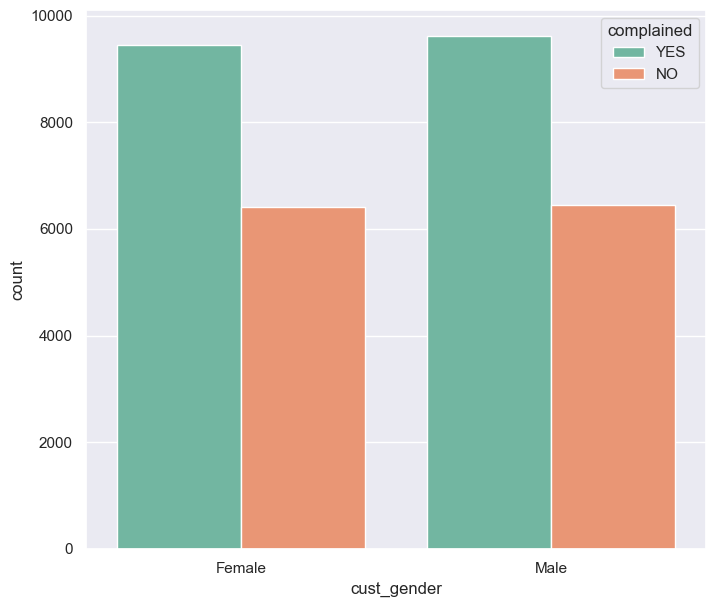

In [13]:
# Checking the relationship of complained customers to other variables

checks = ['merchandize_category',
       'restaurant_points', 'fuel_points', 'groceries_points', 'toys_points',
       'cash_back_points', 'electronics', 'Order_tyPe','card_vendor', 'used_coupon', 'product_discounted',
       'cust_age', 'cust_gender']

for f in checks:
    sns.countplot(x=f, data = new_data, palette= 'Set2', hue= 'complained')
    plt.show()

### Feature Engineering

In [14]:
# Changing categorical variables into Quantiative

feature = ['merchandize_category','Order_tyPe','card_vendor', 'used_coupon', 'product_discounted','cust_gender']

new_data2 = pd.get_dummies(new_data, columns= feature)

# print the shape
print(new_data.shape)
print(new_data2.shape)

# Creating a new 0-1 y variable
new_data2['complained'][new_data2['complained']  == 'YES'] = 1
new_data2['complained'][new_data2['complained']  == 'NO'] = 0

new_data2

(31924, 19)
(31924, 52)


,amount_deposited_via_counter,amount_deposited_via_card,balance_on_complaign_date,restaurant_points,fuel_points,groceries_points,toys_points,cash_back_points,electronics,complained,...,Order_tyPe_sender_mno_TTCL,Order_tyPe_via app,card_vendor_Mastercard,card_vendor_Visa,used_coupon_No,used_coupon_Yes,product_discounted_YEs,product_discounted_no,cust_gender_Female,cust_gender_Male
0,0.0,779.00,1272.00,0,0,0,0,0,0,1,...,False,False,False,True,True,False,False,True,True,False
1,0.0,536.00,928.00,0,1,0,0,0,0,1,...,False,False,False,True,True,False,False,True,True,False
2,0.0,330225.00,177850.00,0,0,0,0,1,0,0,...,False,False,False,True,True,False,False,True,False,True
3,0.0,6215561.04,301542.04,3,0,1,0,1,0,0,...,False,False,True,False,True,False,True,False,True,False
4,0.0,6215561.04,301542.04,3,0,1,0,1,0,0,...,False,False,True,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31919,0.0,889252.00,82795.01,4,0,0,0,4,0,0,...,False,False,False,True,True,False,False,True,True,False
31920,0.0,216721.13,110494.13,0,0,1,0,0,0,0,...,False,False,True,False,True,False,True,False,True,False
31921,1500000.0,1500000.00,1500000.00,0,0,0,0,0,0,0,...,False,False,False,True,True,False,False,True,True,False
31922,0.0,173690.13,2747.13,0,0,0,0,6,0,0,...,False,False,False,True,True,False,False,True,True,False


In [15]:
new_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31924 entries, 0 to 31923
Data columns (total 52 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   amount_deposited_via_counter                               31924 non-null  float64
 1   amount_deposited_via_card                                  31924 non-null  float64
 2   balance_on_complaign_date                                  31924 non-null  float64
 3   restaurant_points                                          31924 non-null  int64  
 4   fuel_points                                                31924 non-null  int64  
 5   groceries_points                                           31924 non-null  int64  
 6   toys_points                                                31924 non-null  int64  
 7   cash_back_points                                           31924 non-null  int64  
 8   electr

We shall normalize some of the features so as to provide better distribution of the data

In [16]:
new_data2['amount_deposited_via_counter'].max()
new_data2['amount_deposited_via_counter'].min()

-5900.0

In [17]:
#normalize the columns

scale_vars = ['amount_deposited_via_counter','amount_deposited_via_card','balance_on_complaign_date','amount'
              ,'quantity','restaurant_points','fuel_points','groceries_points','toys_points','cash_back_points','electronics','cust_age']
scaler = MinMaxScaler()
new_data2[scale_vars] = scaler.fit_transform(new_data2[scale_vars])
new_data2.head()

,amount_deposited_via_counter,amount_deposited_via_card,balance_on_complaign_date,restaurant_points,fuel_points,groceries_points,toys_points,cash_back_points,electronics,complained,...,Order_tyPe_sender_mno_TTCL,Order_tyPe_via app,card_vendor_Mastercard,card_vendor_Visa,used_coupon_No,used_coupon_Yes,product_discounted_YEs,product_discounted_no,cust_gender_Female,cust_gender_Male
0,0.000008,0.000286,0.000018,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1,...,False,False,False,True,True,False,False,True,True,False
1,0.000008,0.000286,0.000018,0.000000,0.043478,0.000000,0.0,0.000000,0.0,1,...,False,False,False,True,True,False,False,True,True,False
2,0.000008,0.000757,0.000271,0.000000,0.000000,0.000000,0.0,0.038462,0.0,0,...,False,False,False,True,True,False,False,True,False,True
3,0.000008,0.009162,0.000447,0.050847,0.000000,0.037037,0.0,0.038462,0.0,0,...,False,False,True,False,True,False,True,False,True,False
4,0.000008,0.009162,0.000447,0.050847,0.000000,0.037037,0.0,0.038462,0.0,0,...,False,False,True,False,True,False,True,False,True,False


-Split the data into X & Y

-Run a Tree-based estimators

-Run Feature Importance

In [18]:
# Split the data into X & Y

X = new_data2.drop('complained', axis= 1).values
y = new_data2['complained']

y = y.astype(int)

print(X.shape)
print(y.shape)


(31924, 51)
(31924,)


In [19]:
# Run a Tree-based estimators (i.e. decision trees & random forests)

dt = DecisionTreeClassifier(random_state=15, criterion= 'entropy', max_depth=10)
dt.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

In [20]:
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(new_data2.drop('complained', axis = 1)):
    print('The feature importance for {} is : {}'.format(column, dt.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

The feature importance for amount_deposited_via_counter is : 0.014493419071987495
The feature importance for amount_deposited_via_card is : 0.06435646856972807
The feature importance for balance_on_complaign_date is : 0.17570880344192966
The feature importance for restaurant_points is : 0.007834486408045198
The feature importance for fuel_points is : 0.002944509726575551
The feature importance for groceries_points is : 0.011936393209842416
The feature importance for toys_points is : 0.0012251027680889488
The feature importance for cash_back_points is : 0.013169626497239705
The feature importance for electronics is : 0.0012800943326937463
The feature importance for amount is : 0.03479720392813285
The feature importance for quantity is : 0.4719415100682041
The feature importance for cust_age is : 0.04411140088075795
The feature importance for merchandize_category_Alcohol is : 0.000256374660842635
The feature importance for merchandize_category_Baking is : 0.0009402810158945756
The featur

In [21]:
# Creating a Dataframe
fi_col
fi

fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df


# Ordering the data
fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()

# Creating columns to keep
columns_to_keep = fi_df['Feature'][0:39]

fi_df

,index,Feature,Feature Importance
0,10,quantity,0.471942
1,2,balance_on_complaign_date,0.175709
2,37,Order_tyPe_Other,0.111535
3,1,amount_deposited_via_card,0.064356
4,11,cust_age,0.044111
5,9,amount,0.034797
6,0,amount_deposited_via_counter,0.014493
7,7,cash_back_points,0.013170
8,5,groceries_points,0.011936
9,3,restaurant_points,0.007834


In [22]:
# Print the shapes

print(new_data2.shape)
print(new_data2[columns_to_keep].shape)

new_data3 = new_data2[columns_to_keep]

(31924, 52)
(31924, 39)


In [23]:
# Split the data into X & y

X = new_data3.values
X

y = new_data2['complained']
y = y.astype(int)
y

print(X.shape)
print(y.shape)


#Training and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=1000)

(31924, 39)
(31924,)


### Running Machine Learning Models

Decision Tree Model

In [24]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=100)

dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=100)

In [25]:
# Accuracy on Train
print("Training Accuracy is: ", dt.score(X_train, y_train))

# Accuracy on Train
print("Testing Accuracy is: ", dt.score(X_test, y_test))

Training Accuracy is:  0.7647488775190561
Testing Accuracy is:  0.7507046664578766


In [26]:
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

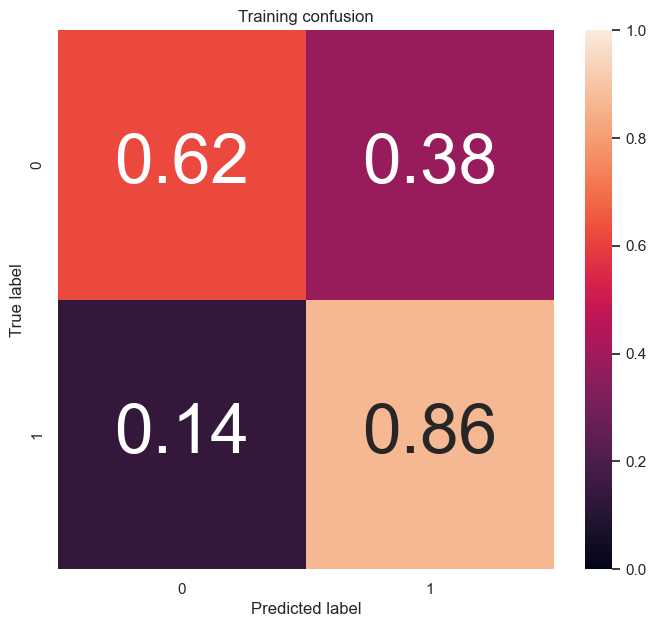

In [27]:
y_pred = dt.predict(X_train)

# Plotting Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Training confusion')

In [28]:
y_pred = dt.predict(X_train)
y_pred
confusion_matrix(y_train, y_pred)

array([[ 7148,  4417],
       [ 2342, 14824]], dtype=int64)

In [29]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print ("The True Positive rate / Recall per class is: ",TPR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print ("The Precision per class is: ",PPV)

# False positive rate or False alarm rate
FPR = FP/(FP+TN)
print ("The False Alarm rate per class is: ",FPR)

# False negative rate or Miss Rate
FNR = FN/(TP+FN)
print ("The Miss Rate rate per class is: ",FNR)

# Classification error
CER = (FP+FN)/(TP+FP+FN+TN)
print ("The Classification error of each class is", CER)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print ("The Accuracy of each class is", ACC)
print("")

##Total averages :
print ("The average Recall is: ",TPR.sum()/2)
print ("The average Precision is: ",PPV.sum()/2)
print ("The average False Alarm is: ",FPR.sum()/2)
print ("The average Miss Rate rate is: ",FNR.sum()/2)
print ("The average Classification error is", CER.sum()/2)
print ("The average Accuracy is", ACC.sum()/2)

The True Positive rate / Recall per class is:  [0.618072 0.863568]
The Precision per class is:  [0.753214 0.770438]
The False Alarm rate per class is:  [0.136432 0.381928]
The Miss Rate rate per class is:  [0.381928 0.136432]
The Classification error of each class is [0.235251 0.235251]
The Accuracy of each class is [0.764749 0.764749]

The average Recall is:  0.7408196427257271
The average Precision is:  0.7618260181473866
The average False Alarm is:  0.2591803572742729
The average Miss Rate rate is:  0.2591803572742729
The average Classification error is 0.23525112248094393
The average Accuracy is 0.7647488775190561


Random Forest

In [30]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
prediction_test = rf.predict(X=X_test)

Training Accuracy is:  0.9776199923427656
Testing Accuracy is:  0.7854682117131224


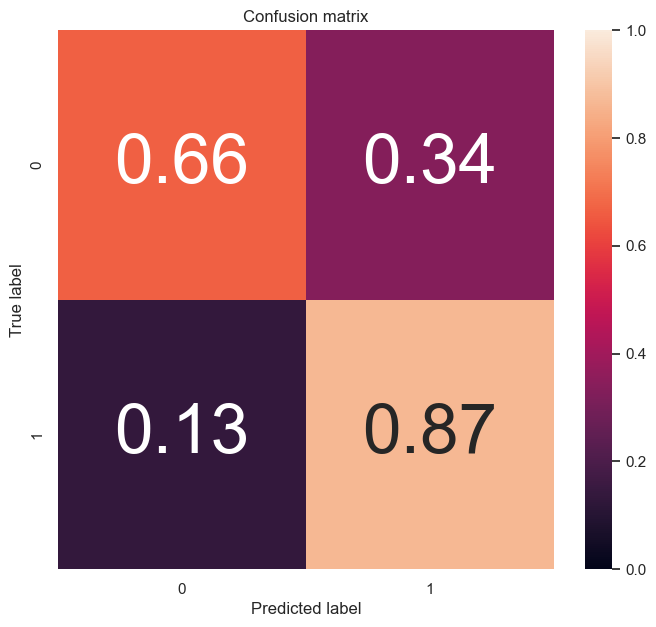

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)



# Accuracy on Test
print("Training Accuracy is: ", rf.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", rf.score(X_test, y_test))

XGBoost

In [32]:
classifier=xgb.XGBClassifier(tree_method='hist')

params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth":[2,3,4,5,6,8,10,12,15],
    "min_child_weight":[1,3,5,7],
    "gamma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7]}

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',cv=5,verbose=3)


# fitting Model
clf.fit(X,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=12, min_child_weight=5;, score=0.816 total time=   5.9s
[CV 2/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=12, min_child_weight=5;, score=0.816 total time=   2.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=12, min_child_weight=5;, score=0.823 total time=   1.9s
[CV 4/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=12, min_child_weight=5;, score=0.798 total time=   1.8s
[CV 5/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=12, min_child_weight=5;, score=0.836 total time=   1.3s
[CV 1/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=5;, score=0.810 total time=   0.6s
[CV 2/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=5;, score=0.811 total time=   0.6s
[CV 3/5] END colsample_by

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [2, 3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [33]:
#Best Parameters
clf.best_params_

{'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.3,
 'gamma': 0.2,
 'colsample_bytree': 0.5}

In [34]:
# fitting the model with the best parameters
clf.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Training Accuracy is:  0.79708328982632
Testing Accuracy is:  0.7832759160663952


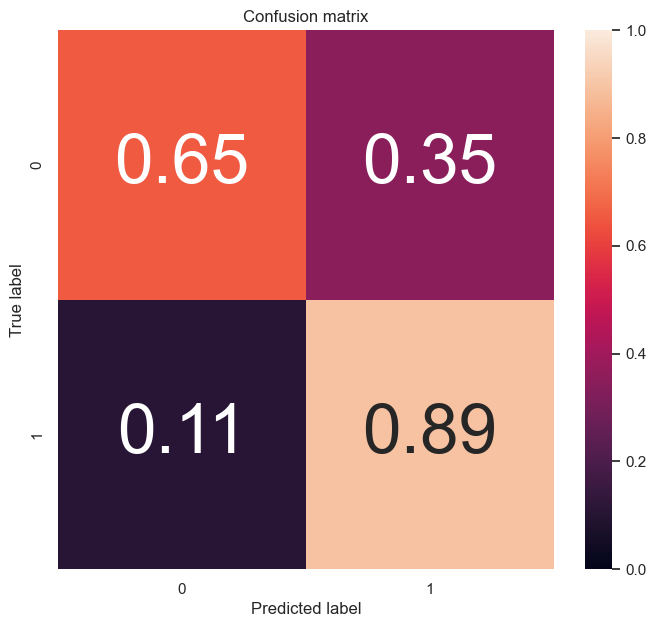

In [35]:
# fiting the model with the best parameters
from numpy import nan


final_model = xgb.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None)
# fitting Final Model
final_model.fit(X,y)



pred_xgboost = final_model.predict(X)

# Confusion Matrix
cm = confusion_matrix(y, pred_xgboost)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)


# Accuracy on Test
print("Training Accuracy is: ", final_model.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", final_model.score(X_test, y_test))

### Conclusion

From the model results we observe:

- Sensitivity(Hit Rate / Recall) is ~0.7 and Specificity is ~0.9
- Accuracy ~ 80%

These models predict more customers will complain